In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 55.4MB/s 


## Import necessary packages

In [3]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models

import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import trange, tqdm
import random
import glob
import dlib
import pandas as pd
import numpy as np
import shutil
from torchsummary import summary
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
GDRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S6_GAN/'

In [5]:
if os.path.exists("data"):
    print("It does exist")
os.mkdir("data")

In [6]:
# Root directory for dataset
dataroot = "./data/car_dataset/"


# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Download dataset

In [7]:
shutil.copy(os.path.join(GDRIVE_PATH,'car_dataset.zip'),'./')

'./car_dataset.zip'

In [8]:
!unzip -q "./car_dataset.zip" -d "./data"

In [9]:
ls "./data/car_dataset/cars" | wc -l

557


## Image sample

In [10]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [11]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

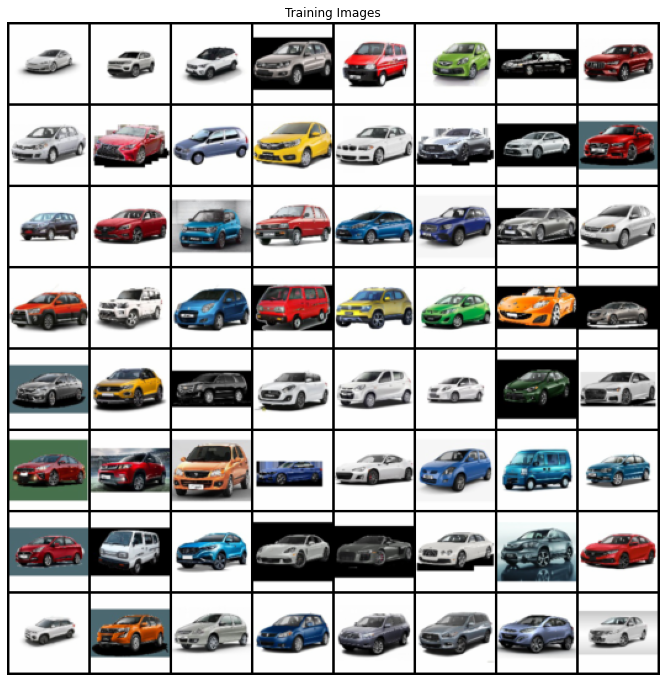

In [12]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Weight Initialization

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## GAN- Generator definition

In [14]:
# Generator model. Takes 100-d latent vector. 100-d -> 4x4x512 -> 8x8x256 -> 16x16x128 -> 32x32x64 -> 64x64x3
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input = z, output=512x4x4
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # output = 256x8x8
            nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # Output = 128x16x16
            nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # Output = 64x32x32
            nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output = 3x64x64
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.Tanh()
            )
        
    def forward(self, input):
        return self.main(input)

Create generator instance

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:
# Generator model summary
summary(netG, input_size=(nz,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

Discriminator

In [17]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Input= 64x32x32 Output = 128x16x16
            nn.Conv2d(in_channels=ndf, out_channels=ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2*ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # Input = 128x16x16 Output=256x8x8
            nn.Conv2d(in_channels=ndf*2, out_channels=ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Input = 256x8x8 Output=512x4x4
            nn.Conv2d(in_channels=ndf*4, out_channels=ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # Input = 512x4x4 Output = 1x1
            nn.Conv2d(in_channels=ndf*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [18]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [19]:
# Discriminator model summary
summary(netD, input_size=(3,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [20]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
fixed_noise.shape

torch.Size([64, 100, 1, 1])

In [22]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_output = []
D_G_z1_output = []
D_G_z2_output = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Save Discriminator output on real and fake images.
        D_x_output.append(D_x)
        D_G_z1_output.append(D_G_z1)
        D_G_z2_output.append(D_G_z2)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/200][0/5]	Loss_D: 1.5064	Loss_G: 4.9882	D(x): 0.6189	D(G(z)): 0.5501 / 0.0108
[1/200][0/5]	Loss_D: 0.2352	Loss_G: 7.6039	D(x): 0.9771	D(G(z)): 0.1680 / 0.0009
[2/200][0/5]	Loss_D: 0.1223	Loss_G: 8.4112	D(x): 0.9873	D(G(z)): 0.0982 / 0.0003
[3/200][0/5]	Loss_D: 0.0153	Loss_G: 7.1928	D(x): 0.9956	D(G(z)): 0.0106 / 0.0013
[4/200][0/5]	Loss_D: 1.7627	Loss_G: 23.5270	D(x): 0.9972	D(G(z)): 0.7653 / 0.0000
[5/200][0/5]	Loss_D: 0.2936	Loss_G: 8.2190	D(x): 0.8895	D(G(z)): 0.0036 / 0.0006
[6/200][0/5]	Loss_D: 0.1349	Loss_G: 20.8571	D(x): 0.9332	D(G(z)): 0.0000 / 0.0000
[7/200][0/5]	Loss_D: 0.2338	Loss_G: 13.7506	D(x): 0.8851	D(G(z)): 0.0000 / 0.0000
[8/200][0/5]	Loss_D: 0.2357	Loss_G: 8.1513	D(x): 0.9848	D(G(z)): 0.1434 / 0.0015
[9/200][0/5]	Loss_D: 1.6297	Loss_G: 13.6470	D(x): 0.4433	D(G(z)): 0.0000 / 0.0000
[10/200][0/5]	Loss_D: 0.4967	Loss_G: 10.3408	D(x): 0.9813	D(G(z)): 0.2673 / 0.0002
[11/200][0/5]	Loss_D: 1.2735	Loss_G: 11.7417	D(x): 0.4831	D(G(z)): 0.0000 / 0

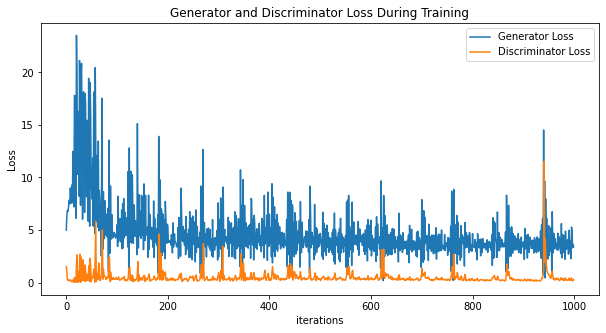

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

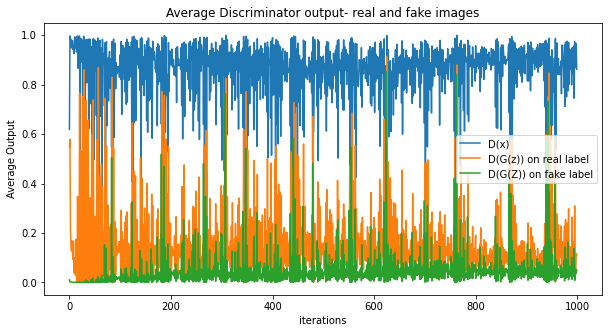

In [24]:
plt.figure(figsize=(10,5))
plt.title("Average Discriminator output- real and fake images")
plt.plot(D_x_output, label="D(x)")
plt.plot(D_G_z1_output,label="D(G(z)) on real label")
plt.plot(D_G_z2_output,label="D(G(Z)) on fake label")
plt.xlabel("iterations")
plt.ylabel("Average Output")
plt.legend()
plt.show()

In [25]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
type(ani)

matplotlib.animation.ArtistAnimation

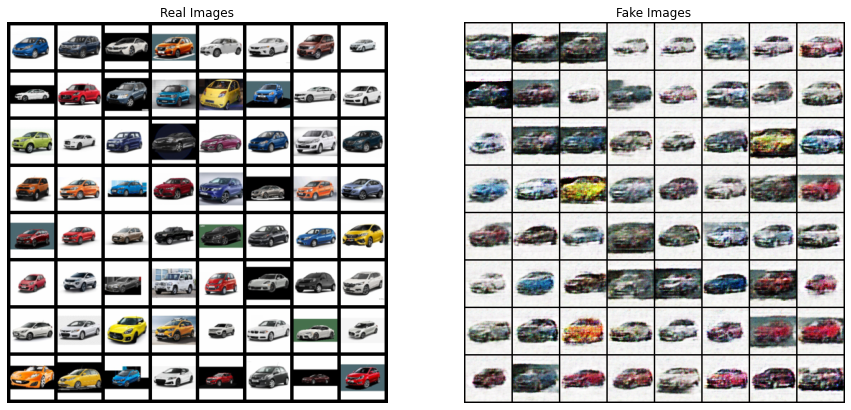

In [26]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [29]:
img = np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0))
img.shape

torch.Size([557, 557, 3])

Model export and check

In [48]:
netG = netG.to(torch.device("cpu"))
netG.eval()
traced_model = torch.jit.trace(netG, torch.randn(1, 100, 1, 1))
traced_model.save("DCGAN_IndianCars.pt")

In [33]:
shutil.move("DCGAN_IndianCars.pt", os.path.join(GDRIVE_PATH, "saved_models"))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S6_GAN/saved_models/DCGAN_IndianCars.pt'

In [40]:
# Verification of the model
noise_verify = torch.randn(1, 100, 1, 1)

In [41]:
img_verify = netG(noise_verify.detach())

In [42]:
img_verify.shape

torch.Size([1, 3, 64, 64])

In [43]:
img_verify = img_verify.detach()
print(img_verify)
print(img_verify.shape)
print(img_verify.max())

tensor([[[[0.8969, 0.9393, 0.9139,  ..., 0.9284, 0.9433, 0.8276],
          [0.9321, 0.9357, 0.9281,  ..., 0.8918, 0.8647, 0.8575],
          [0.9268, 0.9361, 0.9255,  ..., 0.8901, 0.8072, 0.8494],
          ...,
          [0.9141, 0.9096, 0.8893,  ..., 0.9145, 0.9377, 0.9159],
          [0.9388, 0.9063, 0.8980,  ..., 0.9411, 0.9649, 0.9369],
          [0.9212, 0.9299, 0.9382,  ..., 0.9567, 0.9547, 0.8989]],

         [[0.8781, 0.9357, 0.9246,  ..., 0.9419, 0.9274, 0.8393],
          [0.9181, 0.9171, 0.9016,  ..., 0.9030, 0.7882, 0.8220],
          [0.9018, 0.9005, 0.8845,  ..., 0.8286, 0.7527, 0.8369],
          ...,
          [0.9055, 0.8720, 0.8759,  ..., 0.8927, 0.8980, 0.9013],
          [0.9208, 0.9200, 0.8881,  ..., 0.9559, 0.9287, 0.9332],
          [0.9156, 0.9550, 0.8865,  ..., 0.9654, 0.9327, 0.8597]],

         [[0.8628, 0.9260, 0.9260,  ..., 0.9445, 0.9345, 0.8523],
          [0.9128, 0.9343, 0.9329,  ..., 0.8789, 0.8672, 0.8242],
          [0.9036, 0.8711, 0.9206,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


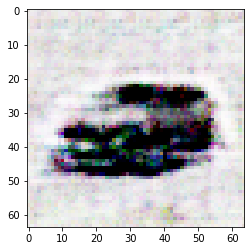

In [44]:
plt.imshow(img_verify.detach().squeeze().permute(1,2,0))

In [39]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)

In [45]:
img_verify = denormalize(img_verify, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

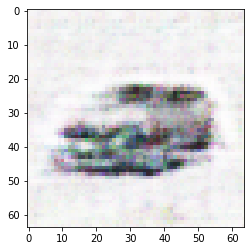

In [46]:
plt.imshow(img_verify.detach().squeeze().permute(1,2,0))

Load model and check

In [6]:
import torch
import matplotlib.pyplot as plt

In [4]:
netG = torch.jit.load('DCGAN_IndianCars.pt')

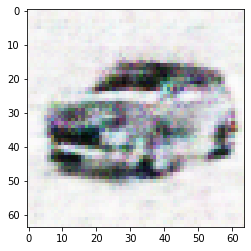

In [55]:
noise_verify = torch.randn(1, 100, 1, 1)
img_verify = netG(noise_verify.detach())
img_verify = denormalize(img_verify, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plt.imshow(img_verify.detach().squeeze().permute(1,2,0))